In [1]:
using CSV
using DataFrames
using Statistics
using Random
using Plots
using Distributions
using ScikitLearn

In [2]:
@sk_import svm: SVR

PyObject <class 'sklearn.svm._classes.SVR'>

$C$: {$10$, $100$, $1000$}

$\gamma$: {$1$, $10^{-1}$, $10^{-2}$}

$\epsilon$: {$10^{-3}$ ; $10^{-4}$ ; $10^{-5}$}

In [119]:
# normalizar serie
function normalizar(serie)
    max = maximum(serie)
    min = minimum(serie)
    
    y_temp = 2 .* ((serie .- min)) ./ (max .- min) .- 1
    
    y = y_temp ./ sqrt(size(serie)[1])
    
    return y
end

function desnormalizar(serie_norm, serie)
    max = maximum(serie)
    min = maximum(serie)
    
    serie_temp = serie_norm .* sqrt(size(serie)[1])
    serie_temp2 = (serie_temp .+ 1)/2
    serie_temp3 = serie_temp2 * ((max - min) + min)
    return serie_temp3 
end

function split_sequence(serie, n_steps_in::Int64)
    len = size(serie)[1]
    max_iter = len - n_steps_in
    seq_x = zeros(max_iter, n_steps_in)
    seq_y = zeros(max_iter)
    for i in 1:len-n_steps_in
        idx = i + n_steps_in - 1
        out_idx = idx + 1
        if out_idx > len
            println(i)
            println("len = ", len)
            println("out_idx = ", out_idx)
            println("Out_idx > len")
            break
        end
        seq_x[i,:] = serie[i:idx]
        seq_y[i] = serie[out_idx]
    end
    return seq_x, seq_y
end

function divisao_dados_temporais(X, y, perc_treino::Float64, perc_val::Float64)
    tam_treino = convert(Int64, floor(perc_treino * size(y)[1]))
    
    if perc_val > 0
        tam_val = convert(Int64, floor(perc_val * size(y)[1]))
        X_treino = X[1:tam_treino,:]
        y_treino = y[1:tam_treino]
        
        X_val = X[tam_treino+1:tam_treino+1+tam_val,:]
        y_val = y[tam_treino+1:tam_treino+1+tam_val]
        
        X_teste = X[(tam_treino+tam_val+1):end,:]
        y_teste = y[(tam_treino+tam_val+1):end]
        
        return X_treino, y_treino, X_teste, y_teste,  X_val, y_val
        
    else
        X_treino = X[1:tam_treino,:]
        y_treino = y[1:tam_treino]
        
        X_teste = X[tam_treino+1:end,:]
        y_teste = y[tam_treino+1:end]
        return X_treino, y_treino, X_teste, y_teste
    end
end

function compute_cost(pred, y)
    m = size(y)[1]
    erro = pred .- y
    cost = 1/m * sum(erro.^2)
    return cost
end

function PSO(X, y, n_particles::Int64, max_iter::Int64, LB, UB, perc_treino::Float64, perc_val::Float64)
    
    mse_treino = zeros(size(y)[2]*max_iter)
    mse_val = zeros(size(y)[2]*max_iter)
    mse_teste = zeros(size(y)[2]*max_iter)
    
    dim = 3
    
    particles = zeros(n_particles, dim)
    particles[:, 1] = rand(Uniform(LB[1], UB[1]), n_particles)
    particles[:, 2] = rand(Uniform(LB[2], UB[2]), n_particles)
    particles[:, 3] = rand(Uniform(LB[3], UB[3]), n_particles)
    
    velocity = zeros(n_particles, dim)
    
    modelo = fit!(SVR(kernel = "rbf", C = particles[1,1], epsilon = particles[1, 2], gamma = particles[1,3]), X[:,:,1], y[:, 1])
    y_pred = predict(modelo, X[:,:,1])
    gbest_value = compute_cost(y_pred, y[:,1])    

    fitness_value = zeros(n_particles)

    for i in eachindex(fitness_value)
        modelo = fit!(SVR(kernel = "rbf", C = particles[i,1], epsilon = particles[i, 2], gamma = particles[i,3]), X[:,:,1], y[:, 1])
        y_pred = predict(modelo, X[:, :, 1])
        fitness_value[i] = compute_cost(y_pred, y[:,1])
    end
    
    id_min = argmin(fitness_value)
    pbest = copy(particles)
    gbest = copy(pbest[id_min, :])

    wmax = 0.9
    wmin = 0.4
    c1 = 1.5
    c2 = 1.5
    
    iteracao = 1
    for janela in 1:size(y)[2]
        
        X_treino, Y_treino, X_teste, Y_teste, X_val, Y_val = divisao_dados_temporais(X[:,:,janela], y[:,janela], perc_treino, perc_val)
        
        X_tv = vcat(X_treino, X_val)
        Y_tv = vcat(Y_treino, Y_val)
        
        for k in 1:max_iter
            w=wmax-(wmax-wmin)*k/max_iter
        
            for i in 1:n_particles
                velocity[i, :] = w*velocity[i,:] .+ c1*rand().*(pbest[i,:] .- particles[i,:]) .+ c2*rand().*(gbest[:] .- particles[i,:])
                particles[i,:] = particles[i,:] .+ velocity[i,:]
            end
            
            # handling boundary violations 
            for i in 1:n_particles
                for j in 1:dim
                    if particles[i,j]<LB[j] 
                        particles[i,j]=LB[j] 
                    elseif particles[i,j]>UB[j] 
                        particles[i,j]=UB[j] 
                    end
                end
            end 

            # evaluating fitness
            for i in 1:n_particles
                modelo = fit!(SVR(kernel = "rbf", C = particles[i,1], epsilon = particles[i, 2], gamma = particles[i,3]), X_treino, Y_treino)
                y_pred = predict(modelo, X_treino)
                fitness_value[i] = compute_cost(y_pred, Y_treino)
                
                # pbest
                modelo_pbest = fit!(SVR(kernel = "rbf", C = pbest[i,1], epsilon = pbest[i, 2], gamma = pbest[i,3]), X_treino, Y_treino)
                y_pred_pbest = predict(modelo, X_treino)
                
                if fitness_value[i] < compute_cost(y_pred_pbest, Y_treino)
                    pbest[i, :] = copy(particles[i, :])
                end
                
                # gbest
                if fitness_value[i] < gbest_value
                    gbest_value = fitness_value[i]
                    gbest = copy(particles[i,:])   
                end

            end

            # updating pbest and fitness
            # for i in 1:n_particles
            #     modelo_pbest = fit!(SVR(kernel = "rbf", C = pbest[i,1], epsilon = pbest[i, 2], gamma = pbest[i,3]), X_treino, Y_treino)
            #     y_pred_pbest = predict(modelo, X_treino)
            #     if fitness_value[i] < compute_cost(y_pred_pbest, Y_treino)
            #         pbest[i, :] = copy(particles[i, :])
            #     end
            # end

            # updating gbest 
            # for i in 1:n_particles    
            #     if fitness_value[i] < gbest_value
            #         gbest_value = fitness_value[i]
            #         gbest = copy(particles[i,:])   
            #     end
            # end
    
            # treinamento mse
            modelo_iter = fit!(SVR(kernel = "rbf", C = gbest[1], epsilon = gbest[2], gamma = gbest[3]), X_tv, Y_tv)
            pred_gbest_tv = predict(modelo_iter, X_tv)
            mse_tv = compute_cost(pred_gbest_tv, Y_tv)
            mse_treino[iteracao] = mse_tv

            # validacao mse
            pred_gbest_val = predict(modelo_iter, X_val)
            mse_v = compute_cost(pred_gbest_val, Y_val)
            mse_val[iteracao] = mse_v

            # teste
            pred_gbest_t = predict(modelo_iter, X_teste)
            mse_t = compute_cost(pred_gbest_t, Y_teste)
            mse_teste[iteracao] = mse_t
            
            iteracao += 1
        end
        
    end
    return mse_treino, mse_val, mse_teste
end

function init_params()
   
    C = rand(Uniform(10, 1000))
    epsilon = rand(Uniform(1e-5, 1e-3))
    gamma = rand(Uniform(1e-2, 1))
    
    params = Dict("C" => C, "epsilon" => epsilon, "gamma" => gamma)
    
    return params
    
end

function svr_model_pso(X, y, num_iteracoes::Int64, perc_treino::Float64, perc_val::Float64)

    
    LB = [1, 1e-5, 1e-2]
    UB = [1000, 1e-3, 1]
    
    mse_treino, mse_val, mse_teste = PSO(X, y, 50, num_iteracoes, LB, UB, perc_treino, perc_val)
        
    return mse_treino, mse_val, mse_teste
end

# janelamento para cenários dinâmicos
function cenarios_dinamicos(serie, window_size::Int64, step_size::Int64)
    
    if ndims(serie) == 1
        w = window_size
        s = step_size
        t = size(serie)[1]

        i_max = convert(Int64,floor((t-w)/s))

        s_temp = serie[(1*s):((1*s)+w-1)]

        cenarios = zeros(0)

        append!(cenarios, s_temp)

        for i in 2:i_max
            s_temp = serie[(i*s):((i*s)+w-1)]
            cenarios = hcat(cenarios, s_temp)
        end
        return cenarios
    else
        w = window_size
        s = step_size
        t = size(serie)[1]

        i_max = convert(Int64,floor((t-w)/s))

        s_temp = serie[(1*s):((1*s)+w-1), :]

        cenarios = zeros(w, size(serie)[2], i_max)

        cenarios[:,:, 1] = s_temp

        for i in 2:i_max
            s_temp = serie[(i*s):((i*s)+w-1),:]
            cenarios[:, :, i] = s_temp
        end
    end
    return cenarios
end

# Criando cenários
function cenarios_execucoes_pso(X, y, w, s, f::Int64, perc_treino::Float64, perc_val::Float64,qtd_execucoes::Int64)
    
    # gerando os cenários dinâmicos
    X_I = cenarios_dinamicos(X, w, s)
    y_I = cenarios_dinamicos(y, w, s)
 
    # calculando a quantidade de iterações
    T = f * size(y_I)[2] 

    println("Quantidade de iterações: ", T)
    
    
    mse_treino = zeros(qtd_execucoes, size(y_I)[2] * f)
    mse_val = zeros(qtd_execucoes, size(y_I)[2] * f)
    mse_teste = zeros(qtd_execucoes, size(y_I)[2] * f)
 
    execucoes = 1:qtd_execucoes

    for execucao in eachindex(execucoes)

        println("Execução: ", execucao)
            
        mse_treino_lista_temp, mse_val_lista_temp, mse_teste_lista_temp = svr_model_pso(X_I, y_I, f, perc_treino, perc_val)

        # salvar lista com os mse de treino para todas as iterações
        mse_treino[execucao, :] = mse_treino_lista_temp
        # salvar lista com os mse de validacao para todas as iteracoes
        mse_val[execucao, :] = mse_val_lista_temp
        # salvar lista com os mse de teste para todas as iterações
        mse_teste[execucao, :] = mse_teste_lista_temp

    end
    
    return mse_treino, mse_val, mse_teste
    
end
      
function avaliacao_resultados(mse_treino_cenarios, mse_val_cenarios, mse_teste_cenarios, f, quantidade_janelas, execucoes)
            
    qtd_iteracoes = size(mse_treino_cenarios)[2]
    
    te = sum(mse_treino_cenarios, dims = 1)./qtd_iteracoes
    
    ge = sum(mse_teste_cenarios, dims = 1)./qtd_iteracoes

    gf = ge./te

    te_medio = mean(te)
    te_std = std(te)

    ge_medio = mean(ge)
    ge_std = std(ge)

    gf_medio = mean(gf)
    gf_std = std(ge)

    println("Te médio: ", te_medio)
    println("TE desvio: ", te_std)
    println("GE medio: ", ge_medio)
    println("GE desvio: ", ge_std)
    println("GF medio: ", gf_medio)
    println("GF desvio: ", gf_std)

    resultados = [te_medio, te_std, ge_medio, ge_std, gf_medio, gf_std]

    return resultados, te, ge

end  

avaliacao_resultados (generic function with 1 method)

In [90]:
sp500 = CSV.read("dados/sp500.csv"; delim=",")
sp500_serie = sp500["valor"]

serie_norm = normalizar(sp500_serie)
se = desnormalizar(serie_norm, sp500_serie)

X, y = split_sequence(serie_norm, 10);

In [91]:
w = 58
s = 10
f = 50

quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

32

In [120]:
Random.seed!(22);

In [121]:
# testando modelo SVR
parametros = Dict("C" => [10, 100, 1000], "epsilon" => [1e-5, 1e-4, 1e-3], "gamma" => [1e-2, 1e-1, 1.])

# treinamento/teste
treino_id = Int(round(0.8*length(y)))

X__treino = X[1:treino_id, :]
y__treino = y[1:treino_id]
X__teste = X[treino_id+1:end, :]
y__teste = y[treino_id+1:end]

# treinamento
modelo = fit!(SVR(kernel = "rbf", C = parametros["C"][1], gamma = parametros["gamma"][1], epsilon = parametros["epsilon"][1]), X__treino, y__treino)

PyObject SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=1e-05, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [122]:
# calcular o custo 
# desnormalizar
treino_desnorm = desnormalizar(y__treino, sp500_serie)
pred_treino = desnormalizar(predict(modelo, X__treino), sp500_serie)
teste_desnorm = desnormalizar(y__teste, sp500_serie)
pred_teste = desnormalizar(predict(modelo, X__teste), sp500_serie)
# treinamento
mse_treino = compute_cost(predict(modelo, X__treino), y__treino)
mse_treino_desnorm = compute_cost(pred_treino, treino_desnorm)
# teste
mse_teste = compute_cost(predict(modelo, X__teste), y__teste)
mse_teste_desnorm = compute_cost(pred_teste, teste_desnorm)

# print
println("MSE treinamento:         $mse_treino")
println("MSE treinamento desnorm: $mse_treino_desnorm")
println("MSE teste:               $mse_teste")
println("MSE teste desnorm:       $mse_teste_desnorm")

MSE treinamento:         7.12887595330906e-5
MSE treinamento desnorm: 0.026694348329778995
MSE teste:               3.0387160896720137e-5
MSE teste desnorm:       0.011378588476540432


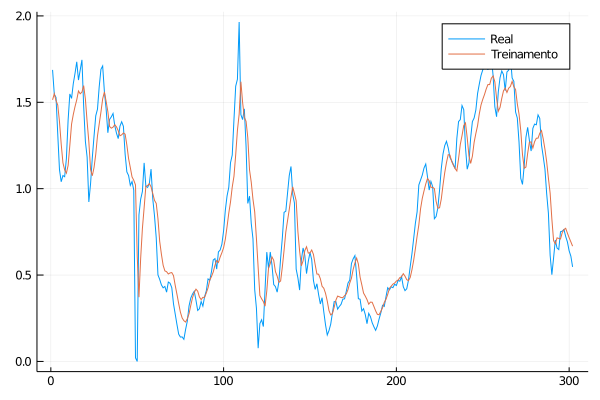

In [95]:
plot(treino_desnorm, label = "Real")
plot!(pred_treino, label = "Treinamento")

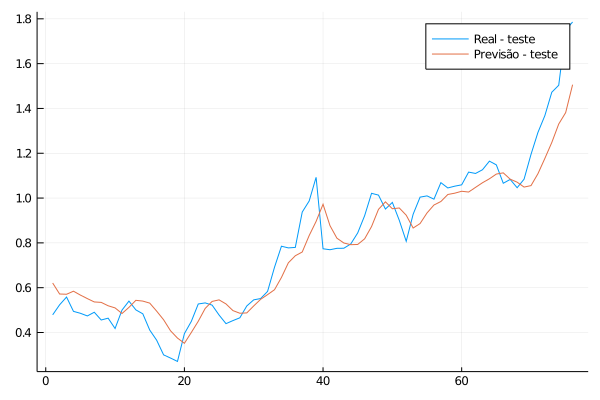

In [96]:
plot(teste_desnorm, label = "Real - teste")
plot!(pred_teste, label = "Previsão - teste")

In [ ]:
@time mse_treino_pso_1, mse_validacao_pso_1, mse_teste_pso_1 = cenarios_execucoes_pso(X, y, w, s, f, 0.54, 0.24, 3);

In [ ]:
resultados_pso_1, mse_treino_1, mse_teste_1 = avaliacao_resultados(mse_treino_pso_1, mse_validacao_pso_1, mse_teste_pso_1, f, quantidade_janelas,3)

In [ ]:
plot(mse_treino_1', label = "Treinamento")
plot!(mse_teste_1', label = "Teste")

In [108]:
# CQSO
function CQSO(X, y, n_particles::Int64, max_iter::Int64, LB, UB, perc_treino::Float64, perc_val::Float64, neutral_p::Int64, rcloud::Float64)
    
    mse_treino = zeros(size(y)[2]*max_iter)
    mse_val = zeros(size(y)[2]*max_iter)
    mse_teste = zeros(size(y)[2]*max_iter)
    
    # quantidade de colunas
    dim = 3

    n = n_particles
    a = zeros(Int64, n)

    for i in 2:n
        if n%i == 0
            a[i] = i
        end
    end

    n_sub_swarms = sort(a[a.!=0])[1]

    # divide the dimensions per subswarm
    num = n
    div = n_sub_swarms

    dimensions_list = zeros(Int64, div)

    for x in 1:div
        if x < num % div
            dimensions_list[x] = 1 + (num ÷ div)
        else
            dimensions_list[x] = 0 + (num ÷ div)
        end
    end

    context_vector = zeros(n_sub_swarms, dim)

    # Create a multiswarm and his velocities
    multi_swarm_vector = zeros(n_sub_swarms, n, dim)
    velocity_vector = zeros(n_sub_swarms, n, dim)
    
    for i_subswarm in 1:n_sub_swarms  
        for i_particle in 1:n_particles
            for j_particle in 1:dim
                context_vector[i_subswarm, j_particle] = rand(Uniform(LB[j_particle], UB[j_particle]))
                multi_swarm_vector[i_subswarm, i_particle, j_particle] = rand(Uniform(LB[j_particle], UB[j_particle]))
            end
        end
    end

    gbest = copy(multi_swarm_vector[1,1,:])
    pbest = copy(multi_swarm_vector[1,1,:])

    sub_swarm_pbest = copy(context_vector[1,:])

    modelo = fit!(SVR(kernel = "rbf", C = sub_swarm_pbest[1], epsilon = sub_swarm_pbest[2], gamma = sub_swarm_pbest[3]), X[:,:,1], y[:, 1])
    
    y_pred = predict(modelo, X[:, :, 1])
    gbest_value = compute_cost(y_pred, y[:, 1])
    pbest_value = copy(gbest_value)

    parametros_gbest = copy(sub_swarm_pbest)
        
    wmax = 0.9
    wmin = 0.4
    c1 = 1.5
    c2 = 1.5
    
    it_idx = 1

    for janela in 1:size(y)[2]

        X_treino, Y_treino, X_teste, Y_teste, X_val, Y_val = divisao_dados_temporais(X[:,:, janela], y[:, janela], perc_treino, perc_val)

        X_tv = vcat(X_treino, X_val)
        Y_tv = vcat(Y_treino, Y_val)

        # Iterações
        # Para cada sub_swarm em multi_swarm_vector
        iteration = 1
            
        while iteration <= max_iter

            w=wmax-(wmax-wmin)*iteration/max_iter

            # for particula in sub_swarm
            for i_sub_swarm in 1:n_sub_swarms

                for i_particle in 1:n_particles
                    # Calcular o fitness 
                    context_copy = copy(context_vector)
                    particle = copy(multi_swarm_vector[i_sub_swarm,i_particle,:])
                    context_copy[i_sub_swarm, :] = copy(particle)

                    modelo = fit!(SVR(kernel = "rbf", C = context_copy[i_sub_swarm,1], epsilon = context_copy[i_sub_swarm, 2], 
                                gamma = context_copy[i_sub_swarm,3]), X_treino, Y_treino)
                    
                    y_pred = predict(modelo, X_treino)
                    fitness_candidate = compute_cost(y_pred, Y_treino)
                    
                    if fitness_candidate < pbest_value
                    # se o fitness da nova particula for melhor, ela vira o pbest
                        pbest = copy(multi_swarm_vector[i_sub_swarm, i_particle, :])
                        pbest_value = copy(fitness_candidate)
                        sub_swarm_pbest = copy(context_copy[i_sub_swarm, :])
                         # feito o pbest devemos atualizar as posições das particulas
                    end

                    if i_particle <= (neutral_p - 1)  

                        # atualiza como PSO vanilla
                        new_velocity = (w*velocity_vector[i_sub_swarm, i_particle, :]) .+ 
                        ((c1 * rand()) * (pbest .- multi_swarm_vector[i_sub_swarm, i_particle, :])) .+
                        ((c2 * rand()) * (gbest .- multi_swarm_vector[i_sub_swarm, i_particle, :]))

                        new_position = new_velocity .+ multi_swarm_vector[i_sub_swarm, i_particle, :]
                        
                        
                    else
                        # atualiza como QSO
                        dist = sqrt(sum((multi_swarm_vector[i_sub_swarm, i_particle, :] .- gbest).^2))
                        normal = rand(Normal(0, 1), dim)
                        uniform = rand(dim)
                        left_size_form = rcloud .* normal
                        
                        
                        if dist == 0
                            break

                        end

                        right_size_form = (uniform.^(1/dimensions_list[i_sub_swarm])) ./ dist
                        new_position = left_size_form .* right_size_form
                            
                        
                    end
                        
                    # handling boundary violations 
                    for j in 1:dim
                        if new_position[j]<LB[j] 
                            new_position[j]=LB[j] 
                        elseif new_position[j]>UB[j] 
                            new_position[j]=UB[j] 
                        end 
                    end 

                    
                    multi_swarm_vector[i_sub_swarm, i_particle, :] = copy(new_position)

                end   

                if pbest_value < gbest_value
                    gbest = copy(pbest)
                    gbest_value = copy(pbest_value)
                    context_vector[i_sub_swarm, :] = copy(sub_swarm_pbest)
                    parametros_gbest = copy(sub_swarm_pbest)
                end
            
                
            end

            # treinamento mse
            modelo_iter = fit!(SVR(kernel = "rbf", C = gbest[1], epsilon = gbest[2], gamma = gbest[3]), X_tv, Y_tv)

            pred_gbest_tv = predict(modelo_iter, X_tv)
            mse_tv = compute_cost(pred_gbest_tv, Y_tv)
            mse_treino[it_idx] = mse_tv
            
#             println("MSE treinamento e validação: $mse_tv")

            # validacao mse
            pred_gbest_val = predict(modelo_iter, X_val)
            mse_v = compute_cost(pred_gbest_val, Y_val)
            mse_val[it_idx] = mse_v
            
#             println("MSE validação:               $mse_v")

            # teste
            pred_gbest_t = predict(modelo_iter, X_teste)
            mse_t = compute_cost(pred_gbest_t, Y_teste)
            mse_teste[it_idx] = mse_t
            
#             println("MSE teste:                   $mse_tv")

            it_idx += 1
            iteration += 1
        end
    end
                         
    return mse_treino, mse_val, mse_teste
end
    
    
function svr_model_cqso(X, y, num_iteracoes::Int64, perc_treino::Float64, perc_val::Float64, neutral_p::Int64, rcloud::Float64)

    parametros = init_params()
    
    qtd_particulas_dim = length(parametros)    
    
    LB = [1, 1e-5, 1e-2]
    UB = [1000, 1e-3, 1]
    
    mse_treino, mse_val, mse_teste = CQSO(X, y, 50, num_iteracoes, LB, UB, perc_treino, perc_val, neutral_p, rcloud)
        
    return mse_treino, mse_val, mse_teste
end


# Criando cenários
function cenarios_execucoes_cqso(X, y, w, s, f::Int64, perc_treino::Float64, perc_val::Float64, qtd_execucoes::Int64, neutral_p::Int64, rcloud::Float64)
    
    # gerando os cenários dinâmicos
    X_I = cenarios_dinamicos(X, w, s)
    y_I = cenarios_dinamicos(y, w, s)
 
    # calculando a quantidade de iterações
    T = f * size(y_I)[2] 

    println("Quantidade de iterações: ", T)
    
    
    mse_treino = zeros(qtd_execucoes, size(y_I)[2] * f)
    mse_val = zeros(qtd_execucoes, size(y_I)[2] * f)
    mse_teste = zeros(qtd_execucoes, size(y_I)[2] * f)
 
    execucoes = 1:qtd_execucoes

    for execucao in eachindex(execucoes)

        println("Execução: ", execucao)
            
        mse_treino_lista_temp, mse_val_lista_temp, mse_teste_lista_temp = svr_model_cqso(X_I, y_I, f, perc_treino, perc_val, neutral_p, rcloud)

        # salvar lista com os mse de treino para todas as iterações
        mse_treino[execucao, :] = mse_treino_lista_temp
        # salvar lista com os mse de validacao para todas as iteracoes
        mse_val[execucao, :] = mse_val_lista_temp
        # salvar lista com os mse de teste para todas as iterações
        mse_teste[execucao, :] = mse_teste_lista_temp

    end
    
    return mse_treino, mse_val, mse_teste
    
end

cenarios_execucoes_cqso (generic function with 1 method)

In [109]:
Random.seed!(2);
neutral_p = 25
rcloud = 0.2
@time mse_treino_cqso_1, mse_validacao_cqso_1, mse_teste_cqso_1 = cenarios_execucoes_cqso(X, y, w, s, f, 0.54, 0.24, 3, neutral_p, rcloud)

Quantidade de iterações: 1600
Execução: 1
Execução: 2
Execução: 3
805.454228 seconds (66.16 M allocations: 3.814 GiB, 0.28% gc time)


([5.789880375278279e-5 5.6291003178100734e-5 … 1.2331662832970705e-5 1.2331662832970705e-5; 5.7684981152715414e-5 5.7064413038961473e-5 … 1.1811006323180157e-5 1.1811006323180157e-5; 5.880213028034935e-5 5.633907680098381e-5 … 1.251460759802707e-5 1.251460759802707e-5], [0.00013600915740221337 0.0001316001351478034 … 6.891809772502259e-6 6.891809772502259e-6; 0.0001349365112323418 0.00013332791175424118 … 7.087862037551079e-6 7.087862037551079e-6; 0.00013825484241730744 0.0001318897689300606 … 6.865347037411518e-6 6.865347037411518e-6], [0.0001497438345158562 0.0001763354595120729 … 2.8487353453276413e-5 2.8487353453276413e-5; 0.0001618321587628182 0.0001802927348877239 … 3.482301113915763e-5 3.482301113915763e-5; 0.00014081571627105107 0.00017598547909464628 … 2.7080782278305374e-5 2.7080782278305374e-5])

In [110]:
resultados_cqso_1, mse_treino_cqso_, mse_teste_cqso_ = avaliacao_resultados(mse_treino_cqso_1, mse_validacao_cqso_1, mse_teste_cqso_1, f, quantidade_janelas,3)

Te médio: 3.309691438028607e-8
TE desvio: 2.986004692126124e-8
GE medio: 1.6900376016148797e-7
GE desvio: 2.639489599692533e-7
GF medio: 8.632597247792667
GF desvio: 2.639489599692533e-7


([3.309691438028607e-8, 2.986004692126124e-8, 1.6900376016148797e-7, 2.639489599692533e-7, 8.632597247792667, 2.639489599692533e-7], [1.0899119699115473e-7 1.0605905813627877e-7 … 2.2910797971361205e-8 2.2910797971361205e-8], [2.827448184685784e-7 3.3288354593402693e-7 … 5.649446679421214e-8 5.649446679421214e-8])

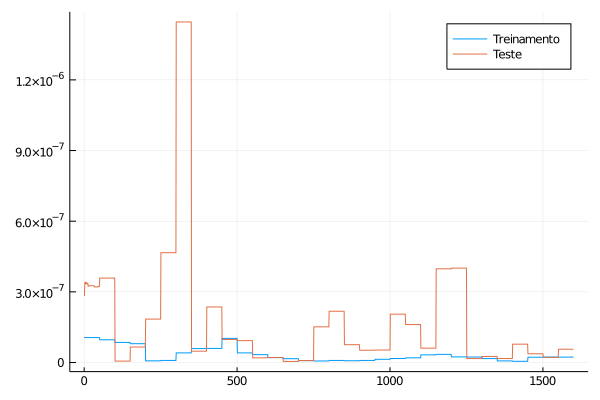

In [116]:
plot(mse_treino_cqso_', label = "Treinamento")
plot!(mse_teste_cqso_', label = "Teste")

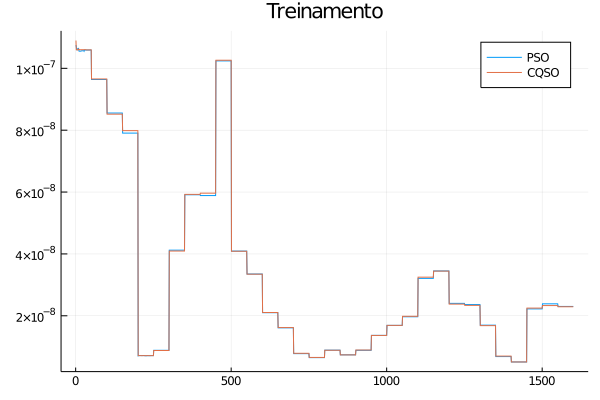

In [117]:
plot(mse_treino_1', label = "PSO", title = "Treinamento")
plot!(mse_treino_cqso_', label = "CQSO")

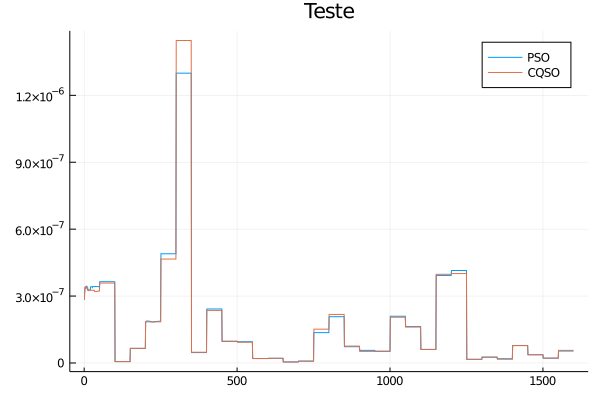

In [118]:
plot(mse_teste_1', label = "PSO", title = "Teste")
plot!(mse_teste_cqso_', label = "CQSO")

In [114]:
resultados_pso_1'

1×6 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 3.30557e-8  2.97823e-8  1.65649e-7  2.43833e-7  8.5361  2.43833e-7

In [115]:
resultados_cqso_1'

1×6 LinearAlgebra.Adjoint{Float64,Array{Float64,1}}:
 3.30969e-8  2.986e-8  1.69004e-7  2.63949e-7  8.6326  2.63949e-7